## Topic modeling on Turkish Refugee Tweets 

<br>
<br>

##  What is topic modeling? 
   
<br>
<br>

Topic Modeling is a technique to extract the hidden topics from large volumes of text.

    
At the moment, the most popular algorithm is LDA (Latent Dirichlet Allocation), but there are a lot of other approaches for short text topic modeling.
Well, in this notebook three algorithms will be introduced:
<br>
<br>

- Topic modeling for short texts (GSDMM);
- Classical approach: LDA models (LDA, LDAMulticore);
- LSI.

# Importing the libraries

In [179]:
import numpy as np 
import pandas as pd

from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [180]:
from sklearn.model_selection import GridSearchCV

# Explore the preprocessed data:

In [181]:
data = pd.read_csv('lemmatized_tweets_for_lda.csv', encoding='utf-8')
data.head()

,Unnamed: 0,Tweets
0,0,uyku “ ülke tane bile mülteci istemek sayıklam...
1,1,ülke mülteci istilâ kurtarmak
2,2,lan mülteci yerleşmek amk ö kadar mi bakmak mü...
3,3,sığınmak göçmenmülteci geçmek yapmak sonra akp...
4,4,biz arkadaş arabistan dönmek ülkemülteci kamp mi


The length of the text is very important for LDA. LDA-model maybe gives a bad quality for short text and we need to try another approach.
See the mean text length of reviews:

In [182]:
data['length'] = data.Tweets.apply(lambda row: len(row.split()))
print('Mean length: ', data['length'].mean())

Mean length:  19.8466


C:\Users\Sercan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='length', ylabel='Density'>

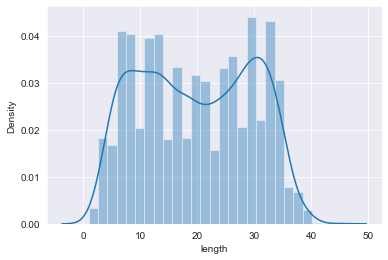

In [183]:
import seaborn as sns
sns.set_style(style="darkgrid")

sns.distplot(data['length'])

LDA model poorly performs on short texts like Tweets, Reddit posts and etc. There is another approach, which is created especially for short text, - GSDMM (Gibbs sampling algorithm for a Dirichlet Mixture Model).

But we also checked LDA-models results and compared them with GSDMM result.


# What is the GSDMM?

Short text clustering is a challenging problem due to its sparse, high-dimensional, and large-volume characteristics. The GSDMM has the following properties:

- GSDMM can infer the number of clusters automatically;
- GSDMM has a clear way to balance the completeness and homogeneity of the clustering results; 
- GSDMM is fast to converge; 
- Unlike the Vector Space Model (VSM)-based approaches, GSDMM can cope with the sparse and highdimensional problem of short texts; 
- Like Topic Models (e.g., PLSA and LDA), GSDMM can also obtain the representative words of each cluster.

Let`s take a closer look at the last point (about comparing it with the most popular topic models):

- In LDA, documents are considered to be a mixture of topics. Short text only deals with one topic (most of the time) so this assumption is not reliable anymore;
- Shorter text means fewer data to rely on during the LDA inference steps.

Well, the Gibbs Sampling Dirichlet Mixture Model (GSDMM) is an “extended” LDA algorithm, that makes the initial assumption: **1 topic is 1 document**. 

The words within a document are generated using the same unique topic, and not from a mixture of topics as it was in the original LDA.

GSDMM is a good choice for short text topic modeling.

In [184]:
data['review_list'] = data.Tweets.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

In [185]:
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [186]:
tokens_reviews = list(sent_to_words(data['review_list']))

In [187]:
tokens_reviews[0]

['uyku', 'ülke', 'tane', 'bile', 'mülteci', 'istemek', 'sayıklamak', 'uyumak', 'bile', 'rahat', 'değil', 'puh']

In [188]:
tokens_reviews = make_n_grams(tokens_reviews)

# GSDMM

Hyper-parameters of the GSDMM model:

- K = 6. It is the number of clusters. We set this value after several experiments in which we started from 15 clusters. As we increased the number of clusters, the empty clusters started to appear. This was why we settled with 6 clusters. 

Hyperparameters; (These default parameters would work for many short texts.)

- alpha =0.01 1 and beta = 0.01. 

- n_iters = 30.  Number of iteration.

In [189]:
np.random.seed(0) #for reproducability

In [191]:
mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=30) 

vocab = set(x for review in tokens_reviews for x in review)
n_terms = len(vocab)
model = mgp.fit(tokens_reviews, n_terms)

In stage 0: transferred 6920 clusters with 6 clusters populated
In stage 1: transferred 3668 clusters with 6 clusters populated
In stage 2: transferred 2620 clusters with 6 clusters populated
In stage 3: transferred 2306 clusters with 6 clusters populated
In stage 4: transferred 2169 clusters with 6 clusters populated
In stage 5: transferred 2084 clusters with 6 clusters populated
In stage 6: transferred 2024 clusters with 6 clusters populated
In stage 7: transferred 1955 clusters with 6 clusters populated
In stage 8: transferred 1922 clusters with 6 clusters populated
In stage 9: transferred 1809 clusters with 6 clusters populated
In stage 10: transferred 1792 clusters with 6 clusters populated
In stage 11: transferred 1771 clusters with 6 clusters populated
In stage 12: transferred 1781 clusters with 6 clusters populated
In stage 13: transferred 1716 clusters with 6 clusters populated
In stage 14: transferred 1778 clusters with 6 clusters populated
In stage 15: transferred 1796 clust

In [192]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [193]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [ 538  353  209 2447 2066 4387]

Most important clusters (by number of docs inside): [5 3 4 0 1 2]

Cluster 5 : [('mülteci', 5130), ('bir', 1655), ('ülke', 1600), ('olmak', 1083), ('demek', 846), ('desen', 732), ('var', 684), ('yok', 662), ('mi', 654), ('bu', 615)]

Cluster 3 : [('mülteci', 2875), ('ülke', 1083), ('bir', 852), ('olmak', 653), ('mi', 412), ('var', 396), ('değil', 381), ('desen', 370), ('demek', 365), ('yok', 336)]

Cluster 4 : [('mülteci', 2568), ('bir', 917), ('ülke', 770), ('olmak', 582), ('demek', 399), ('değil', 377), ('desen', 344), ('var', 332), ('bu', 316), ('mi', 316)]

Cluster 0 : [('mülteci', 659), ('ülke', 183), ('bir', 106), ('suriye', 99), ('olmak', 98), ('milyon', 92), ('para', 74), ('var', 72), ('türkiye', 72), ('vermek', 71)]

Cluster 1 : [('mülteci', 405), ('bir', 76), ('ülke', 62), ('demek', 61), ('kendi', 52), ('vatandaş', 52), ('olmak', 51), ('suriye', 45), ('milyon', 45), ('mi', 44)]

Cluster 2 : [('mülteci', 287), ('

In [194]:
# We didn`t rename the clusters

topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6'
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [195]:
def create_topics_dataframe(data_text=data.Tweets,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=tokens_reviews):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        #result.at[i, 'Rating'] = data.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(tokens_reviews[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [196]:
result = create_topics_dataframe(data_text=data.Tweets, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=tokens_reviews)
result.head(5)

,Text,Topic,Rating,Lemma-text
0,uyku “ ülke tane bile mülteci istemek sayıklam...,type 1,NaN,"[uyku, ülke, tane, bile, mülteci, istemek, say..."
1,ülke mülteci istilâ kurtarmak,type 6,NaN,"[ülke, mülteci, istilâ, kurtarmak]"
2,lan mülteci yerleşmek amk ö kadar mi bakmak mü...,type 3,NaN,"[lan, mülteci, yerleşmek, amk, kadar, mi, bakm..."
3,sığınmak göçmenmülteci geçmek yapmak sonra akp...,type 2,NaN,"[sığınmak, göçmenmülteci, geçmek, yapmak, sonr..."
4,biz arkadaş arabistan dönmek ülkemülteci kamp mi,type 2,NaN,"[biz, arkadaş, arabistan, dönmek, ülkemülteci,..."


# Visualization for the GSDM model:

In [197]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [198]:
result['len'] = result.Text.apply(lambda row: len(row.split()))
result.head()

,Text,Topic,Rating,Lemma-text,len
0,uyku “ ülke tane bile mülteci istemek sayıklam...,type 1,NaN,"[uyku, ülke, tane, bile, mülteci, istemek, say...",13
1,ülke mülteci istilâ kurtarmak,type 6,NaN,"[ülke, mülteci, istilâ, kurtarmak]",4
2,lan mülteci yerleşmek amk ö kadar mi bakmak mü...,type 3,NaN,"[lan, mülteci, yerleşmek, amk, kadar, mi, bakm...",35
3,sığınmak göçmenmülteci geçmek yapmak sonra akp...,type 2,NaN,"[sığınmak, göçmenmülteci, geçmek, yapmak, sonr...",14
4,biz arkadaş arabistan dönmek ülkemülteci kamp mi,type 2,NaN,"[biz, arkadaş, arabistan, dönmek, ülkemülteci,...",7


Let`s explore the mean of length for each type of topics/ratings:

In [143]:
# import library from gensim  
from gensim.models import CoherenceModel

# define function to get words in topics
def get_topics_lists(model, top_clusters, n_words):
    '''
    Gets lists of words in topics as a list of lists.
    
    model: mgp instance
    top_clusters:  numpy array containing indices of top_clusters
    n_words: top n number of words to include
    
    '''
    # create empty list to contain topics
    topics = []
    
    # iterate over top n clusters
    for cluster in top_clusters:
        #create sorted dictionary of word distributions
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]
         
        #create empty list to contain words
        topic = []
        
        #iterate over top n words in topic
        for k,v in sorted_dict:
            #append words to topic list
            topic.append(k)
            
        #append topics to topics list    
        topics.append(topic)
    
    return topics

# get topics to feed to coherence model
topics = get_topics_lists(mgp, top_index, 20) 

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics, 
                          dictionary=dictionary, 
                          corpus=vocab, 
                          texts=texts,
                          coherence='c_v')

# get coherence value
coherence_gsdmm = cm_gsdmm.get_coherence()  

print(coherence_gsdmm)

0.32131525591719845


In [21]:
import matplotlib.pyplot as plt

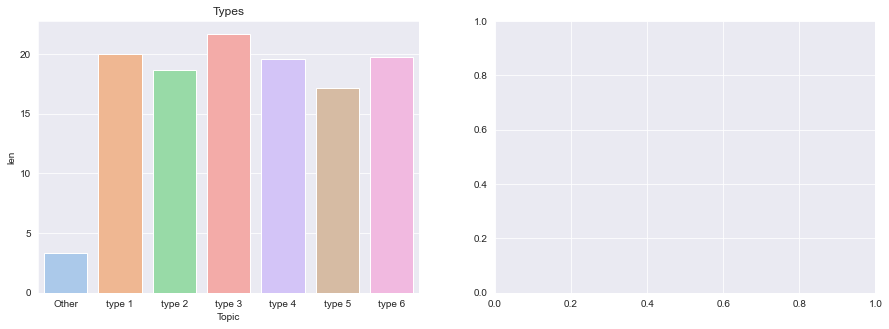

In [22]:
types_len = result.groupby(by=['Topic']).mean()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Types')
types = sns.barplot(x = types_len.index, y = types_len['len'], palette="pastel",  ax=ax[0])

## WordClouds:

In [199]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [200]:
result = result.drop('Lemma-text', axis=1)

In [201]:
from wordcloud import WordCloud 

In [202]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

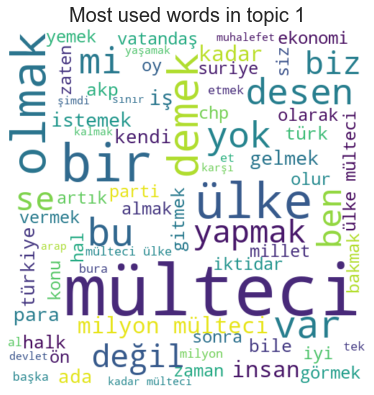

In [203]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")

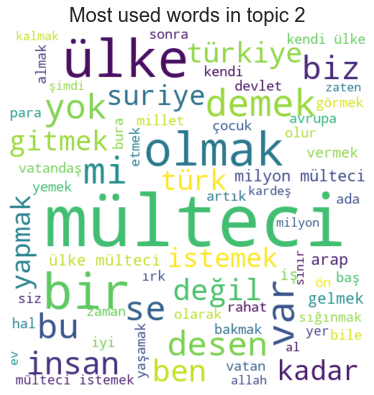

In [204]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")

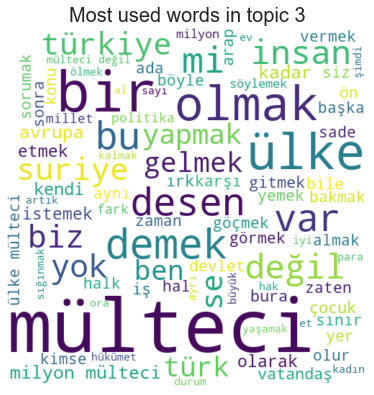

In [205]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

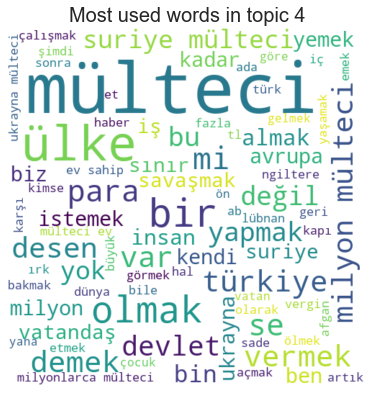

In [206]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

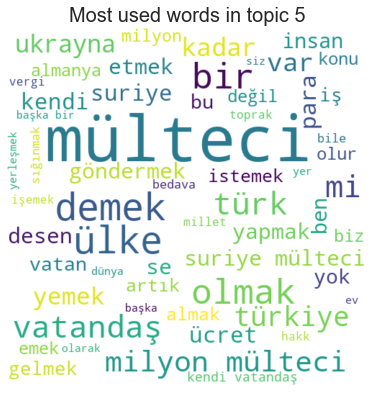

In [207]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

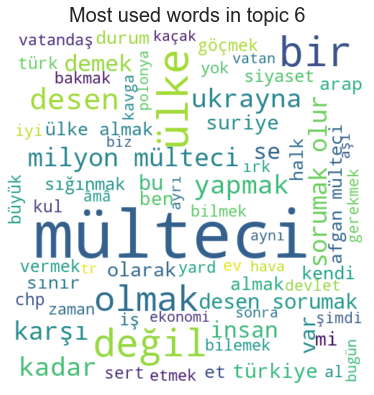

In [208]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in topic 6")

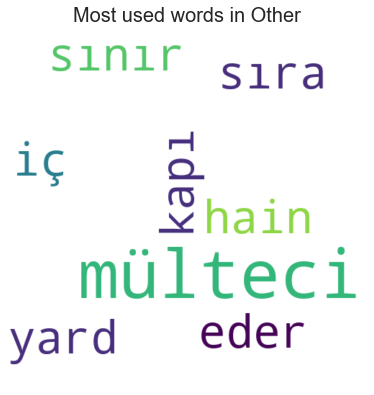

In [209]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'Other'], title="Most used words in Other")

# LDA 

In [50]:
#Creating term dictionary of corpus, where each unique term is assigned an index.
dictionary = corpora.Dictionary(tokens_reviews)

In [53]:
#Filter terms which occurs in less than 1 query and more than 80% of the queries.
dictionary.filter_extremes(no_below=1, no_above=0.8)
#convert the dictionary to a bag of words corpus 
corpus = [dictionary.doc2bow(tokens) for tokens in tokens_reviews]
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [54]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]] #id2word = dictionary 

[[('bile', 2),
  ('değil', 1),
  ('istemek', 1),
  ('puh', 1),
  ('rahat', 1),
  ('sayıklamak', 1),
  ('tane', 1),
  ('uyku', 1),
  ('uyumak', 1),
  ('ülke', 1)]]

In [91]:
#LDA
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=15,
                                           alpha='symmetric', #hyperparameters set after GridSearchCV. Default: alpha=0.1, eta=0.1.
                                           eta=0.7,
                                           per_word_topics=True)
ldamodel.save('mOdel.gensim')#save model
topics = ldamodel.print_topics(num_words=30)#words in each topic group

In [92]:
from pprint import pprint

In [93]:
pprint(ldamodel.print_topics())

[(0,
  '0.030*"ırk" + 0.016*"ukrayna" + 0.009*"aşı" + 0.008*"nefret" + '
  '0.007*"başlamak" + 0.006*"eğitim" + 0.005*"faşist" + 0.003*"taliban" + '
  '0.002*"el_kol" + 0.002*"slâm"'),
 (1,
  '0.016*"an" + 0.009*"yerinmek" + 0.007*"hoca" + 0.004*"statü" + 0.003*"bölü" '
  '+ 0.002*"smail" + 0.002*"batı" + 0.002*"twitter" + 0.002*"nema" + '
  '0.001*"the"'),
 (2,
  '0.007*"silâh" + 0.006*"dışarı" + 0.006*"evlât" + 0.005*"saat" + '
  '0.004*"kimlik" + 0.004*"te" + 0.003*"öz" + 0.003*"mil" + 0.002*"dağ" + '
  '0.002*"tıkmak"'),
 (3,
  '0.017*"turist" + 0.008*"pkk" + 0.007*"terörist" + 0.004*"test" + '
  '0.003*"maske" + 0.003*"yaka" + 0.003*"mamoğlu" + 0.002*"virüs" + '
  '0.002*"masa" + 0.002*"bulaşmak"'),
 (4,
  '0.010*"savaş" + 0.004*"büyümek" + 0.002*"bakarım" + 0.002*"matrix" + '
  '0.001*"dinamik" + 0.001*"tv" + 0.001*"geçilmiyor" + 0.001*"youtube" + '
  '0.001*"giriyorlar" + 0.001*"danimarka"'),
 (5,
  '0.011*"stanbul" + 0.010*"müslüman" + 0.008*"pay" + 0.005*"bari" + '
  '0.002*"s

In [94]:
get_document_topics = ldamodel.get_document_topics(corpus[0])
print(get_document_topics)

[(6, 0.92437375)]


In [95]:
#LDA
import gensim
import pyLDAvis.gensim

In [96]:
#visualizing topics
lda_viz = gensim.models.ldamodel.LdaModel.load('mOdel.gensim')#load lda model
lda_display = pyLDAvis.gensim.prepare(lda_viz, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

C:\Users\Sercan\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [97]:
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data["Tweets"]):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data["Tweets"])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.9244,"ülke, bir, olmak, demek, var, mi, değil, se, b...",uyku “ ülke tane bile mülteci istemek sayıklam...
1,1,6.0,0.7749,"ülke, bir, olmak, demek, var, mi, değil, se, b...",ülke mülteci istilâ kurtarmak
2,2,6.0,0.9727,"ülke, bir, olmak, demek, var, mi, değil, se, b...",lan mülteci yerleşmek amk ö kadar mi bakmak mü...
3,3,6.0,0.8170,"ülke, bir, olmak, demek, var, mi, değil, se, b...",sığınmak göçmenmülteci geçmek yapmak sonra akp...
4,4,6.0,0.8864,"ülke, bir, olmak, demek, var, mi, değil, se, b...",biz arkadaş arabistan dönmek ülkemülteci kamp mi
...,...,...,...,...,...
9995,9995,6.0,0.7996,"ülke, bir, olmak, demek, var, mi, değil, se, b...",işçi bulmak konu zor yaşamak iş var eleman yok...
9996,9996,6.0,0.8075,"ülke, bir, olmak, demek, var, mi, değil, se, b...",biri desen allah kitap demek oy toplamak nas v...
9997,9997,6.0,0.7464,"ülke, bir, olmak, demek, var, mi, değil, se, b...",nidal zaten sorumak ora i̇sveç kura başka kita...
9998,9998,6.0,0.8183,"ülke, bir, olmak, demek, var, mi, değil, se, b...",yıldız bugün gün mülteci ülke dönmek günü se g...


# Model Tuning

In [98]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.


Perplexity:  -8.110614409335028


In [100]:
coherence_model_lda = CoherenceModel(

   model=ldamodel, texts=tokens_reviews, dictionary=dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)
#Okay Coherence Score for LDA after hyperparameters. 


Coherence Score:  0.5403733944815357


In [72]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

For the LDA model, calculating coherence scores for related hyperparameters and number of topics to tune the algorithm. We can try out a different number of topics, and different values of alpha and beta(eta) to increase the coherence score. High coherence score is good for our model.

In [ ]:
def calculate_coherence_score(n, alpha, beta):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=tokens_reviews, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

#list containing various hyperparameters
no_of_topics = [2,5,7,10,12,14]
alpha_list = ['symmetric',0.2,0.3,0.4]
beta_list = ['auto',0.2,0.3,0.4]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")

Means of LDA coherence score:

- 0.3 is bad
- 0.4 is low
- 0.55 is okay
- 0.65 might be as good as it is going to get
- 0.7 is nice
- 0.8 is unlikely
- 0.9 is probably wrong

the highest coherence score:

    n : 10 ; alpha : symmetric ; beta : 0.7 ; Score : 0.7011236056887038  #these hypterparameters were fed to the algorith above.

In [102]:
def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_listlda = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha="symmetric", eta=0.7)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_listlda, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 20, limit = 30, step = 2)

model created
0.36309177933729225
model created
0.3812383879568639
model created
0.36553782203835544
model created
0.3915489018288002
model created
0.3624019916686411


The reason why our model performed to poorly migth be because we didn't perform TF-IDF. 

# LDAMulticore

In [34]:
id2word = corpora.Dictionary(tokens_reviews)
texts = tokens_reviews
corpus = [id2word.doc2bow(text) for text in texts]

In [35]:
# Use TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [174]:
from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=0.3, eta=0.4, random_state = 42) #These alpha and beta values were changed after the GridSearchCV. 
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 5, limit = 30, step = 2)

model created
0.2908691624823013
model created
0.3093959580939812
model created
0.3091044790021907
model created
0.31745868260198923
model created
0.32234783797487176
model created
0.3271585931151474
model created
0.3314080563792346
model created
0.324355295366607
model created
0.33014237978367017
model created
0.322272643218894
model created
0.32179065862309036
model created
0.3178194023881024
model created
0.3091302720654848


# LDA Multicore GridSearchCV

In [41]:
!pip install GridSearchCV

ERROR: Could not find a version that satisfies the requirement GridSearchCV (from versions: none)
ERROR: No matching distribution found for GridSearchCV


In [ ]:
Finding the necesssary alpha and eta for LDAMulticore. 

In [172]:
def calculate_coherence_score(n, alpha, beta):
    ldamodel = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=tokens_reviews, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

#list containing various hyperparameters
no_of_topics = [14,18,20]
alpha_list = ['symmetric',0.2,0.3,0.4]
beta_list = ['auto',0.2,0.3,0.4]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")

n : 14 ; alpha : symmetric ; beta : auto ; Score : 0.6262702180861871
n : 14 ; alpha : symmetric ; beta : 0.2 ; Score : 0.6427836900119379
n : 14 ; alpha : symmetric ; beta : 0.3 ; Score : 0.6695197583319071
n : 14 ; alpha : symmetric ; beta : 0.4 ; Score : 0.675049914282785
n : 14 ; alpha : 0.2 ; beta : auto ; Score : 0.6063982117358713
n : 14 ; alpha : 0.2 ; beta : 0.2 ; Score : 0.6565758369813592
n : 14 ; alpha : 0.2 ; beta : 0.3 ; Score : 0.6687269123378468
n : 14 ; alpha : 0.2 ; beta : 0.4 ; Score : 0.6606047493976287
n : 14 ; alpha : 0.3 ; beta : auto ; Score : 0.6075642557326502
n : 14 ; alpha : 0.3 ; beta : 0.2 ; Score : 0.6493590166487151
n : 14 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.6650500553104214
n : 14 ; alpha : 0.3 ; beta : 0.4 ; Score : 0.6694745588160725
n : 14 ; alpha : 0.4 ; beta : auto ; Score : 0.6191026386674029
n : 14 ; alpha : 0.4 ; beta : 0.2 ; Score : 0.6292528763853485
n : 14 ; alpha : 0.4 ; beta : 0.3 ; Score : 0.6620452130169862
n : 14 ; alpha : 0.4 ; beta 

Means of LDA coherence score:

- 0.3 is bad
- 0.4 is low
- 0.55 is okay
- 0.65 might be as good as it is going to get
- 0.7 is nice
- 0.8 is unlikely
- 0.9 is probably wrong


n : 20 ; alpha : 0.3 ; beta : 0.4 ; Score : 0.6867411762569979

In [74]:
import matplotlib.pyplot as plt

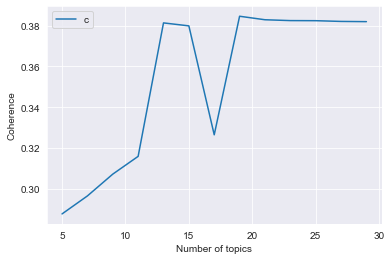

In [170]:
limit, start, step = 30, 5, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show() #20 is the best number of topics. Cohrenece Scores are still bad. We might try other techniques to fix this. 

In [176]:
index = coherence_values.index(max(coherence_values))
model_list[index].show_topics()

[(15, '0.001*"var" + 0.001*"ülke" + 0.001*"bir" + 0.001*"olmak" + 0.001*"mi" + 0.001*"demek" + 0.001*"yok" + 0.001*"desen" + 0.001*"bu" + 0.001*"suriye"'), (4, '0.002*"ülke" + 0.002*"bir" + 0.002*"olmak" + 0.001*"desen" + 0.001*"var" + 0.001*"mi" + 0.001*"değil" + 0.001*"demek" + 0.001*"milyon" + 0.001*"kadar"'), (8, '0.001*"ülke" + 0.001*"bir" + 0.001*"var" + 0.001*"olmak" + 0.001*"demek" + 0.001*"biz" + 0.001*"ben" + 0.001*"desen" + 0.001*"se" + 0.001*"değil"'), (1, '0.002*"ülke" + 0.001*"yok" + 0.001*"demek" + 0.001*"olmak" + 0.001*"suriye" + 0.001*"bir" + 0.001*"istemek" + 0.001*"bu" + 0.001*"mi" + 0.001*"kadar"'), (3, '0.002*"bir" + 0.002*"ülke" + 0.002*"olmak" + 0.001*"istemek" + 0.001*"değil" + 0.001*"ben" + 0.001*"bu" + 0.001*"var" + 0.001*"yok" + 0.001*"milyon"'), (0, '0.001*"ülke" + 0.001*"bir" + 0.001*"sınır" + 0.001*"desen" + 0.001*"olmak" + 0.001*"kadar" + 0.001*"mi" + 0.001*"istemek" + 0.001*"ben" + 0.001*"biz"'), (14, '0.001*"biz" + 0.001*"ülke" + 0.001*"bir" + 0.001*"ol

In [177]:
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(model_list[index], corpus_tfidf, id2word, sort_topics = False)
pyLDAvis.display(lda_display)

C:\Users\Sercan\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [79]:
def format_topics_sentences(lda_model, corpus, data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [80]:
df_topic_sents_keywords = format_topics_sentences(model_list[index], corpus_tfidf, texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.5212,"ulke, bir, olmak, mi, se, var, degil, baska, p...","[uyku, ulke, tane, bile, multeci, istemek, say..."
1,1,27.0,0.3801,"ulke, bir, olmak, yok, istemek, demek, ben, tu...","[ulke, multeci, istila, kurtarmak]"
2,2,0.0,0.6191,"ulke, bir, degil, olmak, mi, turk, milyon, var...","[lan, multeci, yerlesmek, amk, kadar, mi, bakm..."
3,3,4.0,0.5551,"bir, ulke, olmak, sonra, turk, turkiye, desen,...","[sıgınmak, gocmenmulteci, gecmek, yapmak, sonr..."
4,4,4.0,0.4786,"bir, ulke, olmak, sonra, turk, turkiye, desen,...","[biz, arkadas, arabistan, donmek, ulkemulteci,..."
5,5,2.0,0.2770,"ulke, demek, bir, yok, kendi, mi, biz, olmak, ...","[bakmak, hele, se, chp, suriye, ilgi, multeci,..."
6,6,1.0,0.4556,"ulke, bir, kendi, olmak, suriye, kadar, bu, mi...","[dso, iklim, multeci, konu, ortak, tavır]"
7,7,13.0,0.6262,"ulke, demek, milyon, bir, bu, desen, olmak, gi...","[multeci, sıgınmak, yad, kacak, gondermek, ist..."
8,8,0.0,0.5849,"ulke, bir, degil, olmak, mi, turk, milyon, var...","[sezgi, tanrıkulu, gibi, parti, ayrılmak, sure..."
9,9,1.0,0.4728,"ulke, bir, kendi, olmak, suriye, kadar, bu, mi...","[millet, hak, etmek, kendi, ulke, multeci, olmak]"


In [83]:
topic_counts = df_dominant_topic.Dominant_Topic.value_counts().sort_values(ascending=True)

Top texts in each topic:

In [84]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head(24)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6681,"ulke, bir, degil, olmak, mi, turk, milyon, var...","[okumak, ozurlu, mu, birader, nere, iyi, olmak..."
1,1.0,0.6720,"ulke, bir, kendi, olmak, suriye, kadar, bu, mi...","[seci, on, asgari_ucret, zam, multeci, ulke, a..."
2,2.0,0.6651,"ulke, demek, bir, yok, kendi, mi, biz, olmak, ...","[alemdar, he_he, kart, dagıtılır, biz, super, ..."
3,3.0,0.6725,"ulke, bu, bir, yok, insan, milyon, demek, olma...","[mrt, bat, yapmak, cahil, ugrasmak, ayrı, isla..."
4,4.0,0.6661,"bir, ulke, olmak, sonra, turk, turkiye, desen,...","[behcet, aksener, bugun, ittifak, davutoglu, s..."
5,5.0,0.6702,"olmak, ulke, demek, istemek, var, suriye, mily...","[baba, bibi, se, erdogan, gercek, bu, gonderec..."
6,6.0,0.6684,"var, ulke, mi, bir, milyon, degil, istemek, tu...","[oruc, tutmak, turk, millet, turk, deger, sayg..."
7,7.0,0.6658,"degil, ulke, bir, milyon, olmak, var, demek, k...","[zaten, parti, bilesen, ifsa, ediyorum, hdp, c..."
8,8.0,0.6746,"ulke, bir, olmak, mi, se, var, degil, baska, p...","[bahar, evet, muktedir, yeni, oluyor, icraatla..."
9,9.0,0.6593,"bir, ulke, mi, var, desen, milyon, olmak, kend...","[fır, maliyet, haber, yok, galiba, artı, bu, y..."


# LSI model

LSI (Latent Semantic Indexing) is a dimensionality reduction technique that projects documents to a lower-dimensional semantic space and, in doing so, causes documents with similar topical content to be close to one another in the resulting space. LSI uses the singular value decomposition (SVD) of the large term-by-document matrix which represents a document collection in an IR system. The latent space is generated automatically based on word co-occurrence in the collection of documents, so the amount of semantic relatedness between documents in the latent space will depend on other documents in the collection. For example, in the document collection consisting of the portion of the worldwide web indexed by Google, the subject matter is diverse, and two documents that both contain words about computer programming languages will be close in the latent space. However, in the collection of documents on the intranet of a software development company, there will be many documents with programming terminology and two documents will only be close if they share many terms.

In [85]:
from gensim.models import LsiModel

In [86]:
def calc_coherence_values_Lsi(dictionary, corpus, texts, limit, start = 2, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, id2word = dictionary, num_topics = num_topics)
        print('model created')
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values_Lsi = calc_coherence_values_Lsi(dictionary = id2word, corpus=corpus_tfidf, texts=texts, start = 2, limit = 30, step =2)

model created
0.2756670803205996
model created
0.326694792299942
model created
0.38358266975699024
model created
0.3481100027911026
model created
0.3469202778583347
model created
0.3897933779519353
model created
0.36411955484093655
model created
0.3885940368302092
model created
0.36878724274145486
model created
0.3557525144006707
model created
0.3704148695518068
model created
0.34250259790116705
model created
0.3784567419024565
model created
0.35273962302666956


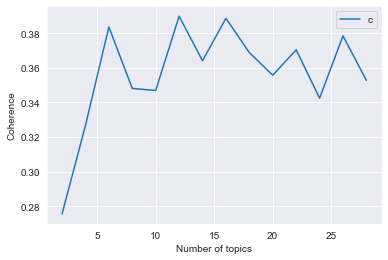

In [87]:
limit, start, step = 30, 2, 2
x = range(start, limit, step)
plt.plot(x, coherence_values_Lsi)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show() 

In [88]:
index = coherence_values_Lsi.index(max(coherence_values_Lsi))
model_list[index].show_topics()

[(0,
  '0.249*"ulke" + 0.209*"bir" + 0.190*"olmak" + 0.164*"demek" + 0.156*"mi" + 0.155*"istemek" + 0.150*"degil" + 0.149*"var" + 0.147*"desen" + 0.142*"yok"'),
 (1,
  '-0.854*"istemek" + -0.333*"ulke" + 0.110*"var" + 0.101*"mi" + 0.097*"yok" + 0.094*"milyon" + -0.082*"hicbir" + -0.067*"kendi" + 0.067*"demek" + -0.056*"gitmek"'),
 (2,
  '0.545*"kendi" + 0.317*"ulke" + 0.294*"vatandas" + 0.273*"olmak" + -0.240*"istemek" + -0.217*"demek" + -0.205*"mi" + 0.176*"beter" + -0.128*"desen" + -0.124*"degil"'),
 (3,
  '0.564*"milyon" + 0.456*"mi" + 0.190*"para" + -0.159*"bir" + 0.145*"var" + -0.137*"ben" + -0.134*"turk" + -0.127*"gitmek" + 0.126*"emek" + 0.116*"ukrayna"'),
 (4,
  '-0.460*"mi" + 0.433*"suriye" + 0.270*"turkiye" + 0.224*"milyon" + 0.205*"afgan" + -0.200*"se" + 0.189*"ukrayna" + -0.153*"kendi" + -0.142*"ben" + 0.140*"turk"'),
 (5,
  '-0.437*"yok" + 0.421*"mi" + 0.285*"degil" + 0.263*"suriye" + -0.241*"milyon" + -0.210*"para" + -0.198*"var" + 0.182*"ukrayna" + -0.175*"biz" + -0.136*